## My Framework Classes

In [1]:
import numpy as np

In [2]:
class Module():
    def __init__(self):
        self._train = True
    
    def forward(self, input):
        raise NotImplementedError

    def backward(self,input, grad_output):
        raise NotImplementedError
    
    def parameters(self):
        return []
    
    def grad_parameters(self):
        return []
    
    def train(self):
        self._train = True
    
    def eval(self):
        self._train = False

In [3]:
class Sequential(Module):
    def __init__ (self, *layers):
        super().__init__()
        self.layers = layers

    def forward(self, input):

        for layer in self.layers:
            input = layer.forward(input)

        self.output = input
        return self.output
        
        for i in range(len(self.layers)-1, 0, -1):
            grad_output = self.layers[i].backward(self.layers[i-1].output, grad_output)
        
        grad_input = self.layers[0].backward(input, grad_output)
        
        return grad_input

    def backward(self, input, grad_output):    
        for i in range(len(self.layers)-1, 0, -1):
            grad_output = self.layers[i].backward(self.layers[i-1].output, grad_output)
        
        grad_input = self.layers[0].backward(input, grad_output)
        
        return grad_input  
    
    def parameters(self):
        res = []
        for l in self.layers:
            res += l.parameters()
        return res
    
    def grad_parameters(self):
        res = []
        for l in self.layers:
            res += l.grad_parameters()
        return res
    
    def train(self):
        for layer in self.layers:
            layer.train()
    
    def eval(self):
        for layer in self.layers:
            layer.eval()

In [4]:
class Linear(Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        
        stdv = 1./np.sqrt(dim_in)
        self.W = np.random.uniform(-stdv, stdv, size=(dim_in, dim_out))
        self.b = np.random.uniform(-stdv, stdv, size=dim_out)

        self.grad_W = None
        self.grad_b = None
        
    def forward(self, input):
        self.output = np.dot(input, self.W) + self.b
        return self.output
    
    def backward(self, input, grad_output):
        self.grad_b = np.mean(grad_output, axis=0)
        
        self.grad_W = np.dot(input.T, grad_output)
        
        grad_input = np.dot(grad_output, self.W.T)
        
        return grad_input
    
    def parameters(self):
        return [self.W, self.b]
    
    def grad_parameters(self):
        return [self.grad_W, self.grad_b]

In [5]:
class ReLU(Module):
    def __init__(self):
         super().__init__()
    
    def forward(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = np.multiply(grad_output, input > 0)
        return grad_input

In [6]:
class LeakyReLU(Module):
    def __init__(self, slope=0.03):
        super().__init__()
            
        self.slope = slope
        
    def forward(self, input):
        self.output = self.slope*input + (1 - self.slope) * np.maximum(input, 0)
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = np.multiply(grad_output, input > 0) + np.multiply(grad_output * self.slope, input <= 0)
        return grad_input

In [7]:
class Sigmoid(Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = np.multiply(input * (1 - input), grad_output)
        return grad_input

In [8]:
class SoftMax(Module):
    def __init__(self):
         super().__init__()
    
    def forward(self, input):
        input = np.subtract(input, input.max(axis=1, keepdims=True))
        exps = np.exp(input)
        self.output = np.true_divide(exps, np.sum(exps, axis=1)[:, None])
        return self.output


    def backward(self, input, grad_output):
        batch_size = input.shape[0]
        s = self.output
        grad_local = -s[..., None] * s[:, None, :]
        iy, ix = np.diag_indices_from(grad_local[0])
        grad_local[:, iy, ix] = s * (1 - s)
        
        for i in range(grad_local.shape[0]):
            grad_local[i] = grad_local[i] * grad_output[i]
    
        grad_input = np.sum(grad_local, 2).reshape(batch_size, -1)
        grad_input = grad_input
        return grad_input

In [9]:
import torch
import torch.nn as nn
my_sm = SoftMax()
torch_sm = nn.Softmax()

In [10]:
my_data = np.random.rand(10, 4) * 10
torch_data = torch.tensor(my_data, requires_grad=True)
print(my_data)
print(torch_data)

[[8.4812987  4.19019668 1.05606188 9.42245453]
 [7.37586809 2.080132   2.25869158 9.76378114]
 [7.24065249 4.83019444 7.49909749 2.50664918]
 [4.93602496 4.48927482 5.6458038  1.30299169]
 [2.41289203 6.46126754 0.37580657 8.96341523]
 [8.37761021 6.76742746 6.15258441 8.41909792]
 [6.37539742 5.93914241 9.7861383  6.42443746]
 [8.93631624 4.51221087 6.26620317 6.31379656]
 [7.23668375 2.24882669 4.39513276 0.65979274]
 [3.88423583 7.36284684 4.71135018 2.23578532]]
tensor([[8.4813, 4.1902, 1.0561, 9.4225],
        [7.3759, 2.0801, 2.2587, 9.7638],
        [7.2407, 4.8302, 7.4991, 2.5066],
        [4.9360, 4.4893, 5.6458, 1.3030],
        [2.4129, 6.4613, 0.3758, 8.9634],
        [8.3776, 6.7674, 6.1526, 8.4191],
        [6.3754, 5.9391, 9.7861, 6.4244],
        [8.9363, 4.5122, 6.2662, 6.3138],
        [7.2367, 2.2488, 4.3951, 0.6598],
        [3.8842, 7.3628, 4.7114, 2.2358]], dtype=torch.float64,
       requires_grad=True)


In [11]:
torch_ans = torch_sm(torch_data)
torch_ans

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[2.7955e-01, 3.8269e-03, 1.6661e-04, 7.1646e-01],
        [8.4021e-02, 4.2119e-04, 5.0353e-04, 9.1505e-01],
        [4.1780e-01, 3.7508e-02, 5.4102e-01, 3.6730e-03],
        [2.7029e-01, 1.7291e-01, 5.4965e-01, 7.1454e-03],
        [1.3192e-03, 7.5595e-02, 1.7203e-04, 9.2291e-01],
        [4.2548e-01, 8.5033e-02, 4.5980e-02, 4.4351e-01],
        [3.0317e-02, 1.9599e-02, 9.1824e-01, 3.1841e-02],
        [8.6666e-01, 1.0387e-02, 6.0012e-02, 6.2937e-02],
        [9.3760e-01, 6.3947e-03, 5.4695e-02, 1.3053e-03],
        [2.7860e-02, 9.0307e-01, 6.3708e-02, 5.3588e-03]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward0>)

In [12]:
t = torch.sum(torch_ans)
t

tensor(10., dtype=torch.float64, grad_fn=<SumBackward0>)

In [13]:
t.grad_fn

In [14]:
t.backward()

In [15]:
t.grad

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


In [16]:
np.random.binomial(1, 0.9, size=[10]).shape

(10,)

In [17]:
class Dropout(Module):
    def __init__(self, drop_probability=0.5):
        super().__init__()

        self.output = None
        self.proba_zero = drop_probability
        self.proba_one = 1 - drop_probability

        self.mask = None

    def forward(self, input):
        if self._train:
            self.mask = np.repeat(np.random.binomial(1, p=self.proba_one,
                                                     size=[input.shape[0], 1]), input.shape[1], axis=1)
            self.output = input * self.mask
        else:
            self.output = input * self.proba_one
        return self.output
    
    def backward(self, input, grad_output):
        if self._train:
            grad_input = self.mask * grad_output * (1 / self.proba_one)
        else:
            grad_input = None
        return grad_input

In [18]:
class BatchNorm(Module):
    def __init__(self, gamma, momentum=1):
        super().__init__()
        self.gamma = gamma
        self.mu = 0
        self.sigma = 1
        self.bias = np.random.uniform(low=-1, high=1)
        self.eps = 1e-8
        self.momentum = momentum
    
    def forward(self, input):
        if self._train:
            new_mu = np.mean(input, axis=0)
            new_sigma = np.var(input, axis=0)

            self.input_norm = (input - new_mu) / np.sqrt(new_sigma + self.eps)
            self.output = self.gamma * self.input_norm + self.bias

            self.mu = (1 - self.momentum) * self.mu + self.momentum * new_mu
            self.sigma = (1 - self.momentum) * self.sigma + self.momentum * new_sigma
        else:
            input_norm = (input - self.mu) / np.sqrt(self.sigma + self.eps)
            self.output = self.gamma * input_norm + self.bias

        return self.output
    
    def backward(self, input, grad_output):
        if self._train:
            self.grad_bias = np.sum(grad_output, axis=0)
            self.grad_gamma = np.sum(grad_output*self.input_norm, axis=0)

            m = input.shape[0]
            t = 1./np.sqrt(self.sigma + self.eps)

            grad_input = (self.gamma * t / m) * (m * grad_output - np.sum(grad_output, axis=0) 
            - t**2 * (input - self.mu) * np.sum(grad_output*(grad_output - self.mu), axis=0))
        else:
            grad_input = None
        return grad_input

    def parameters(self):
        return [self.bias, self.gamma]

    def grad_parameters(self):
        return [self.grad_bias, self.grad_gamma]

In [19]:
class Criterion:
    def forward(self, input, target):
        raise NotImplementedError

    def backward(self, input, target):
        raise NotImplementedError

In [20]:
class MSE(Criterion):
    def forward(self, input, target):
        batch_size = input.shape[0]
        self.output = np.sum(np.power(input - target, 2)) / batch_size
        return self.output

    def backward(self, input, target):
        grad_input = (input - target) * 2 / input.shape[0]
        return grad_input

In [21]:
class CrossEntropy(Criterion):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        # чтобы нигде не было взятий логарифма от нуля:
        eps = 1e-3
        input_clamp = np.clip(input, eps, 1 - eps)

        self.output = np.mean(np.sum(target * np.log(input_clamp), axis=1), axis=None)
        return self.output

    def backward(self, input, target):
        eps = 1e-3
        input_clamp = np.clip(input, eps, 1 - eps)

        grad_input = input_clamp - target
        return grad_input

In [22]:
class Optimizer:
    def __init__(self):
        pass

    def step(self, params, gradients):
        pass

In [23]:
class SGD(Optimizer):
    def __init__(self, learning_rate_init=1e-3):
        super().__init__()
        self.learning_rate = learning_rate_init

    def step(self, params, gradients):
        for weights, gradient in zip(params, gradients):
            weights -= self.learning_rate * gradient

In [24]:
class Adam(Optimizer):
    def __init__(self, b1=0.9, b2=0.999, epsilon=1e-5, learning_rate_init=1e-3):
        super().__init__()
        self.num_optimizers = None
        self.learning_rate = learning_rate_init
        self.b1 = b1
        self.b2 = b2
        self.epsilon = epsilon
        self.total_calls = 1

        self.m = None
        self.v = None

    def step(self, params, gradients):
        it = 0
        if self.m is None:
            self.m = [0] * len(params)
            self.v = [0] * len(params)

        for weights, gradient in zip(params, gradients):
            self.m[it] = self.b1 * self.m[it] + (1 - self.b1) * gradient
            self.v[it] = self.b2 * self.v[it] + (1 - self.b2) * gradient**2

            m_hat = self.m[it] / (1 - np.power(self.b1, self.total_calls))
            v_hat = self.v[it] / (1 - np.power(self.b2, self.total_calls))

            weights -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

            it += 1

        self.total_calls += 1

## DataLoader and gradient clipping

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def grad_clipping(gradients, max_clip=1):
    # ans = []
    for gradient in gradients:
        gradient.clip(0, 0)
    # return ans

In [27]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

## Regression problem

In [28]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = (np.dot(X, true_w).reshape(n) + np.random.randn(n)/5).reshape(n, 1)

print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))

best_possible_mse: 22.705255493608096


In [29]:
epochs = 20
batch_size = 1000
learning_rate = 1e-2

In [30]:
def block(input_size, output_size):
    return Sequential(
        Linear(input_size, output_size),
        LeakyReLU(),
        Dropout(drop_probability=0.3)
    )

In [31]:
model = Sequential(
    block(10, 5),
    block(5, 3),
    Linear(3, 1)
)

criterion = MSE()

In [32]:
optimizer = Adam(learning_rate_init=learning_rate)

In [33]:
def criterion_xy_loss(model, X, y_true):
    model.eval()
    y_pred = model.forward(X)
    return criterion.forward(y_pred, y_true)

0 11.545226859537589
100 2.9931425081440777
200 3.0118221419455873
300 3.0093565931411645
400 3.0150009265612745
500 3.0405306698242804
600 3.013485270505981
700 3.019105266517174
800 3.005077075589724
900 2.9808719284437597


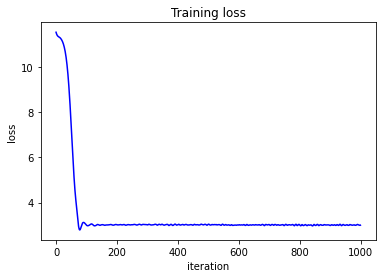

In [34]:
history = []

for i in range(1000):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        model.train()

        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        
        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        grad_clipping(model.grad_parameters(), max_clip=0)
        optimizer.step(model.parameters(),
                       model.grad_parameters())


        history.append(criterion_xy_loss(model, x, y_true))
    if i % 100 == 0:
        print(i, history[-1])

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history[:], 'b')
plt.show()

## Classification problem

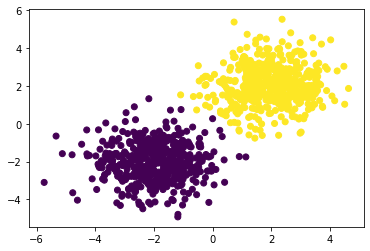

In [74]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

In [75]:
def block(input_size, output_size):
    return Sequential(
        Linear(input_size, output_size),
        ReLU(),
        Dropout(drop_probability=0.5)
    )

In [76]:
model = Sequential(
    block(2, 100),
    block(100, 150),
    block(150, 100),
    block(100, 50),
    block(50, 30),
    block(30, 10),
    block(10, 5),

    Linear(5, 2),
    SoftMax()
)

criterion = CrossEntropy()

In [77]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)
criterion = CrossEntropy()

In [78]:
optimizer = Adam(learning_rate_init=learning_rate)

In [79]:
epochs = 100
batch_size = 20
learning_rate = 1e-2

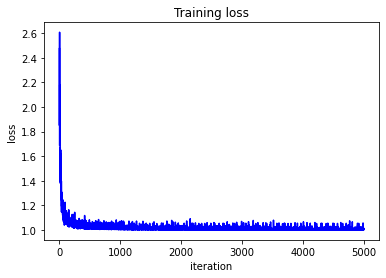

In [80]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        model.train()

        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)

        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)

        # обновляем веса
        grad_clipping(model.grad_parameters(), max_clip=0)
        optimizer.step(model.parameters(),
                       model.grad_parameters())


        history.append(1 - criterion_xy_loss(model, x, y_true))

plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [81]:
def accuracy(y_true, y_pred):
    y_max = np.argmax(y_true, axis=1)
    y_pr = np.argmax(y_pred, axis=1)
    return np.sum(y_max == y_pr) / y_true.shape[0]

In [82]:
print(accuracy(model.forward(X), Y))

0.999


## Now MNIST - real-life problem

In [45]:
import os
from sklearn.datasets import fetch_openml

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_openml("mnist_784")
    # очень важно его отнормировать -- см. Linear в hw_framework
    X = mnist.data / 255.0
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

In [46]:
import pandas as pd
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [47]:
y_ = pd.get_dummies(y, columns=['y'])
y_

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
69995,0,0,1,0,0,0,0,0,0,0
69996,0,0,0,1,0,0,0,0,0,0
69997,0,0,0,0,1,0,0,0,0,0
69998,0,0,0,0,0,1,0,0,0,0


 Train - validation split

In [48]:
X_ = X.to_numpy()
y_ = y_.to_numpy()

In [49]:
mask = np.random.permutation(np.arange(y.shape[0]))

X_ = X_[mask]
y_ = y_[mask]

train_shape = 50000
X_train, X_val = X_[:train_shape , :], X_[train_shape: , :]
y_train, y_val = y_[:train_shape, :], y_[train_shape: , :]

## Fit

In [50]:
def accuracy_Xy(model, X, y_true):
    model.eval()
    y_pred = model.forward(X)
    return accuracy(y_true, y_pred)

In [59]:
def block(input_size, output_size):
    return Sequential(
        Linear(input_size, output_size),
        LeakyReLU()
    )

In [60]:
def seq_by_sizes(sizes):
    ans = []
    for i in range(len(sizes) - 2):
        for j in block(sizes[i - 1], sizes[i]):
            ans.append(j)

    ans.append(Linear(sizes[-2], sizes[-1]))
    ans.append(SoftMax())

    return Sequential(ans)

In [68]:
model = Sequential(
    block(784, 500),
    block(500, 200),
    block(200, 50),
    block(50, 25),

    Linear(25, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = Adam(learning_rate_init=1e-3)

In [69]:
epochs = 5
batch_size = 128

acc 0.9457
loss 0.20460850545850212
acc 0.96194
loss 0.14278487371092333
acc 0.97214
loss 0.10688100827806823
acc 0.98116
loss 0.07694749715252273
acc 0.98562
loss 0.058771021849013616


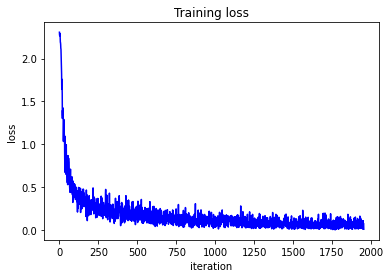

In [70]:
history = []

for i in range(epochs):
    for x, y_true in loader(X_train, y_train, batch_size):
        model.train()

        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)

        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)

        grad_clipping(model.grad_parameters(), max_clip=0.4)
        optimizer.step(model.parameters(),
                       model.grad_parameters())

        history.append(- criterion_xy_loss(model, x, y_true))
    print('acc', accuracy_Xy(model, X_train, y_train))
    print('loss', - criterion_xy_loss(model, X_train, y_train))
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [71]:
print(np.argmax(model.forward(X_train), axis=1)[:30])
print(np.argmax(y_train, axis=1)[:30])
# y_pr = np.argmax(y_pred, axis=1)

[9 4 9 5 9 6 8 8 7 3 9 0 2 6 3 3 1 2 7 1 8 8 6 2 6 2 5 6 9 8]
[9 4 9 5 9 6 8 8 7 3 9 0 2 6 3 3 1 2 7 1 8 8 6 2 6 2 5 6 9 8]


Seems good